# Checking with Liner Regression, KNN, K-Means, Decision Tree, Random Forest Algorithims

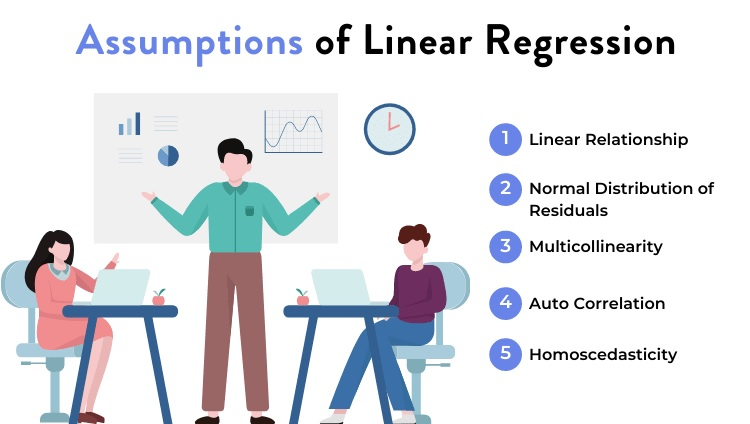

Table of Content
<br><a href="#linearity">1. Linearity</a>
<br><a href="#mean">2. Mean of Residuals</a>
<br><a href="#homo">3. Check for Homoscedasticity</a>
<br><a href="#normal">4. Check for Normal distribution of error terms/residuals</a>
<br><a href="#auto">5. No autocorrelation of residuals</a>
<br><a href="#multico">6. No multicollinearity</a>

In [139]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import os

import seaborn as sns
import matplotlib.pyplot as plt


#Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score,accuracy_score
from sklearn.model_selection import train_test_split


In [140]:
ad_data = pd.read_csv('Advertising.csv')

In [141]:
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [142]:
ad_data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


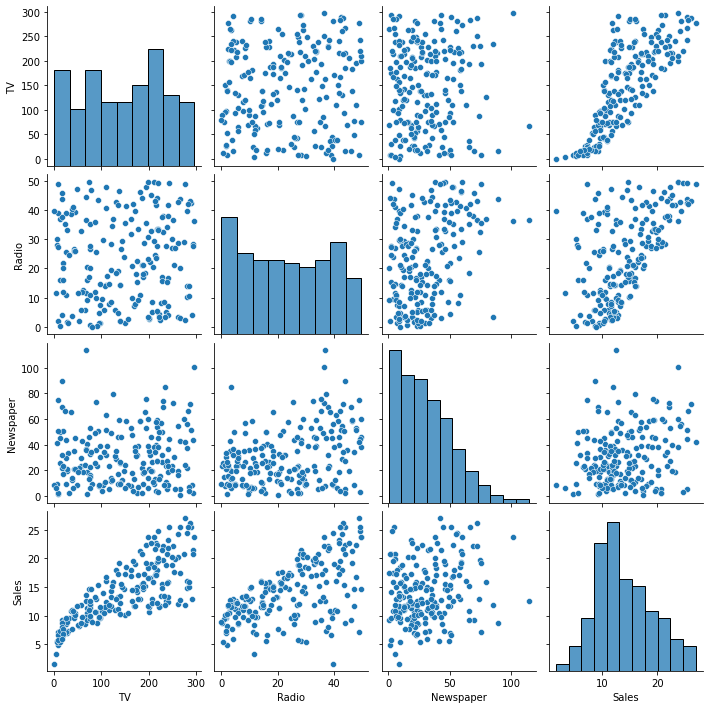

In [143]:
p = sns.pairplot(ad_data)

#  Assumptions for Linear Regression

## <a id="linearity">1. Linearity</a>


linear regression needs the relationship between the independent and dependent variables to be linear. 

It is also important to check for outliers since linear regression is sensitive to outlier effects.  

The linearity assumption can best be tested with scatter plots.

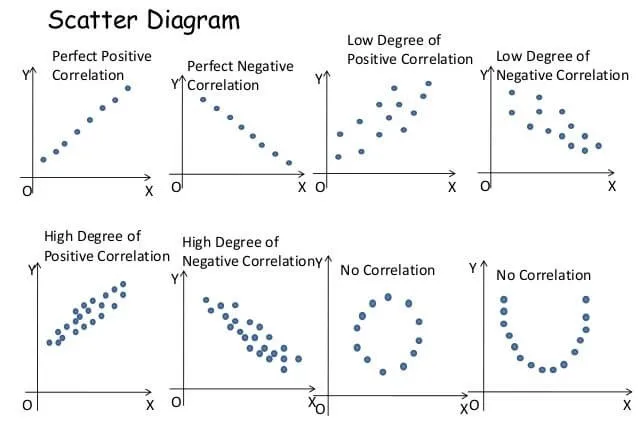

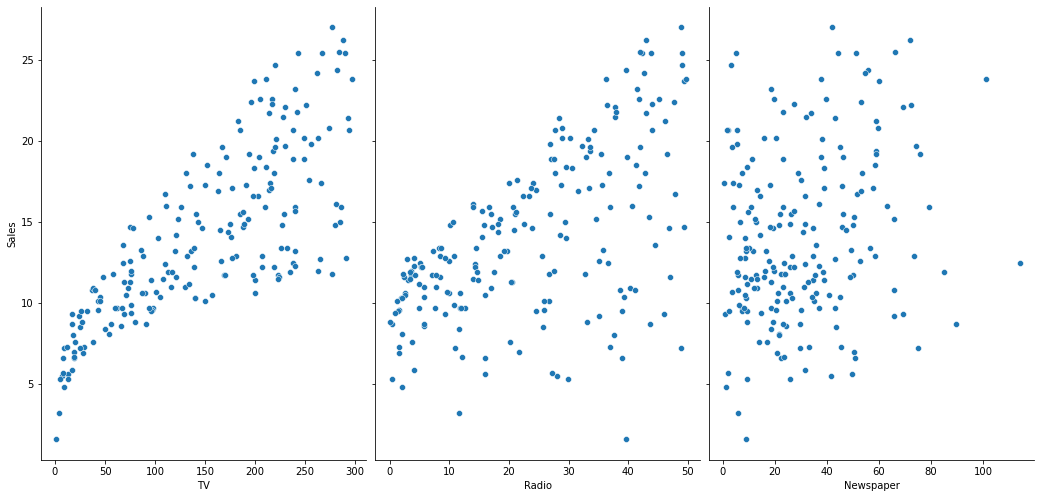

In [144]:
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(ad_data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=7, aspect=0.7)

we can see that with the Sales variable none of the independent variables form an accurately linear shape but TV and Radio do still better than Newspaper which seems to hardly have any specific shape.

So it shows that a linear regression fitting might not be the best model for it or we can also remove newspaper while model building


# Exploratory Data Analysis

<AxesSubplot:>

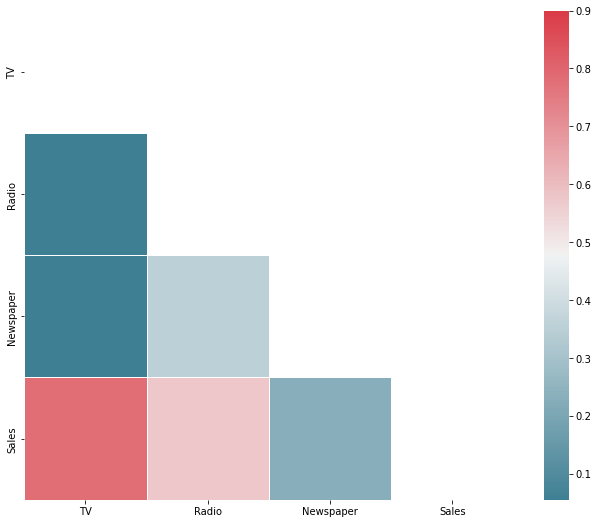

In [145]:
# Generate a mask for the upper triangle
mask = np.zeros_like(ad_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(ad_data.corr(), mask=mask, cmap=cmap, vmax=.9, square=True, linewidths=.5, ax=ax)

Backing up the findings using correlation, the relationship between Sales and TV is more linear.

Now, let's look at the relationship between the predictors.

Text(0.5, 1.0, 'Radio vs Radio')

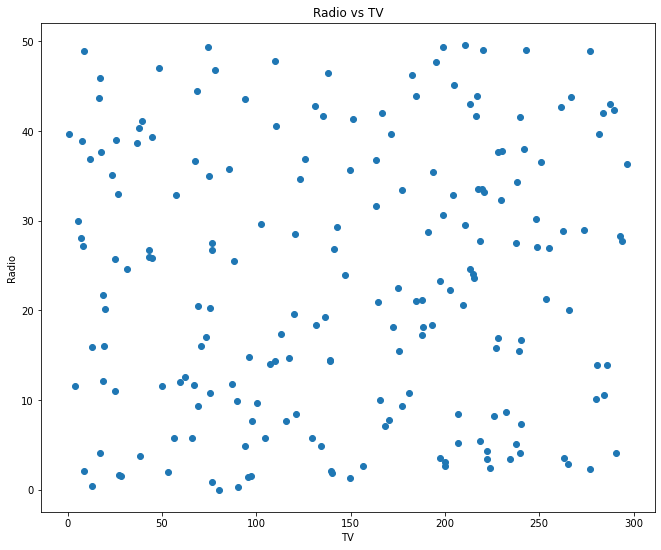

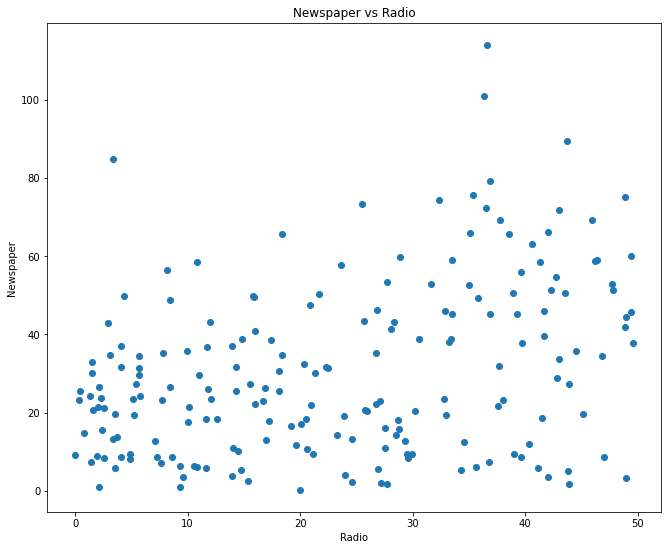

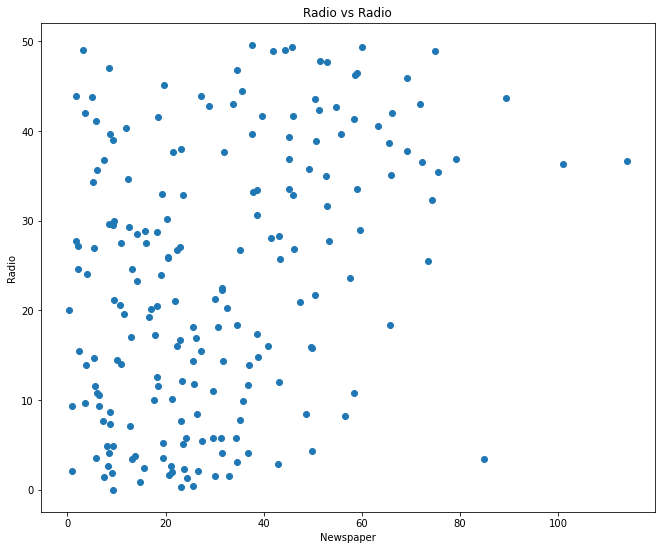

In [146]:
### Visualize the relationship using scatterplot

f, ax = plt.subplots(figsize=(11, 9))
plt.scatter(ad_data["TV"], ad_data["Radio"])
plt.xlabel("TV")
plt.ylabel("Radio")
plt.title("Radio vs TV")

f, ax = plt.subplots(figsize=(11, 9))
plt.scatter(ad_data["Radio"], ad_data["Newspaper"])
plt.xlabel("Radio")
plt.ylabel("Newspaper")
plt.title("Newspaper vs Radio")

f, ax = plt.subplots(figsize=(11, 9))
plt.scatter(ad_data["Newspaper"], ad_data["Radio"])
plt.xlabel("Newspaper")
plt.ylabel("Radio")
plt.title("Radio vs Radio")

It seems there's no clear linear relationships between the predictors.

At this point, we know that the variable TV will more likely give better prediction of Sales because of the high correlation and linearity of the two.

### Missing value check

In [147]:
ad_data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

No missing data

### Outlier handling

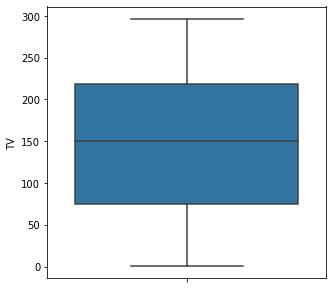

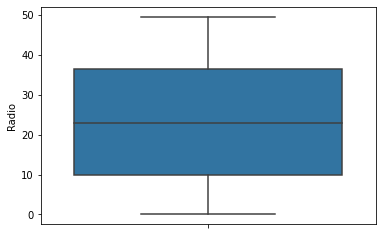

<AxesSubplot:ylabel='Newspaper'>

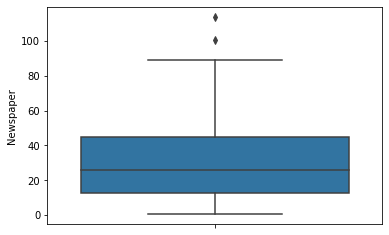

In [148]:
f, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(y='TV',data=ad_data)
plt.show()
sns.boxplot(y='Radio',data=ad_data)
plt.show()
sns.boxplot(y='Newspaper',data=ad_data)


In [12]:
Q1=ad_data['Newspaper'].quantile(0.25)
Q3=ad_data['Newspaper'].quantile(0.75)
IQR=Q3-Q1
pos_outlier=Q3+1.5*IQR
neg_outlier=Q1-1.5*IQR

ad_data = ad_data[~((ad_data < (Q1 - 1.5 * IQR)) |(ad_data > (Q3 + 1.5 * IQR))).any(axis=1)]

<AxesSubplot:ylabel='Newspaper'>

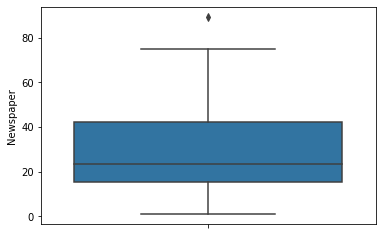

In [13]:
sns.boxplot(y='Newspaper',data=ad_data)

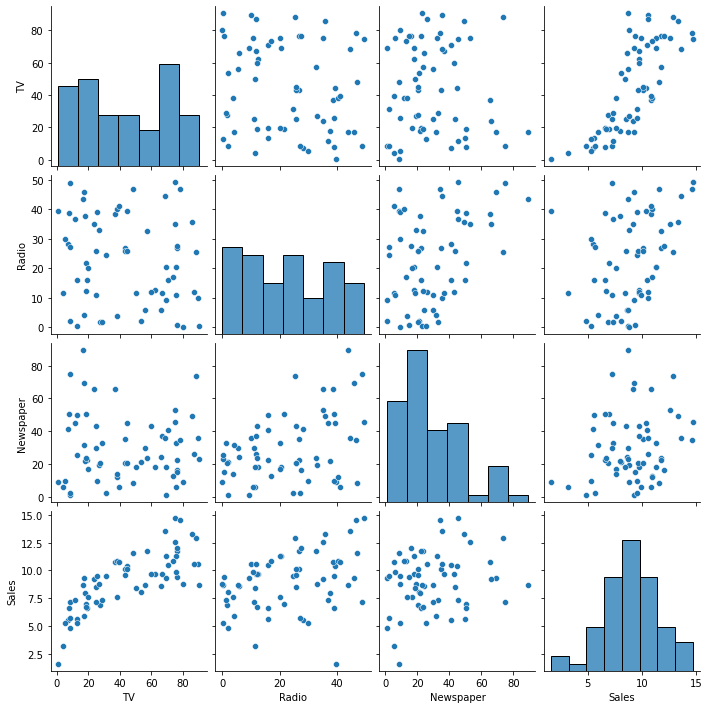

In [14]:
sns.pairplot(ad_data)

### Check Normalization

<AxesSubplot:xlabel='Sales', ylabel='Density'>

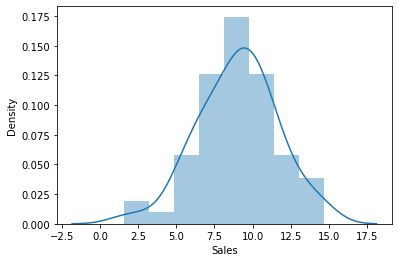

In [15]:
sns.distplot(ad_data['Sales'])

It is a normal distribution

### Now rest of the assumptions require us to perform the regression before we can even check for them. So let's perform regression on it.

## Prep the Data for Modelling

##### Create Feature and Label datasets

In [149]:
x = ad_data.drop(["Sales"],axis=1)
y = ad_data.Sales

In [150]:
x.head()

,TV,Radio,Newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4


In [151]:
y.head()

0    22.1
1    10.4
2     9.3
3    18.5
4    12.9
Name: Sales, dtype: float64

### Fitting the linear model

##### train_test_split the model

In [152]:
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state = 0, test_size=0.25)

In [153]:
print("X_train" , X_train.shape)
print("y_train" , y_train.shape)
print("X_test" , X_test.shape)
print("y_test" , y_test.shape)

X_train (150, 3)
y_train (150,)
X_test (50, 3)
y_test (50,)


#### Perform 'Feature' Scaling

In [154]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [155]:
X_train = sc.fit_transform(X_train)

In [156]:
X_test = sc.transform(X_test)

In [157]:
X_train

array([[-0.52286826, -0.60474345,  0.09678234],
       [ 0.89568081,  0.61159096,  2.18119928],
       [ 1.18365694, -0.13172451,  0.01340566],
       [ 0.36713204, -0.15199675, -0.37895517],
       [-1.29435986,  0.17235909, -0.44761832],
       [-1.08578456, -0.71961948, -0.56042206],
       [ 1.64702594,  0.34129443,  0.66080104],
       [ 0.22018125, -0.34796174,  0.04773724],
       [ 0.57570734, -0.06415038,  0.09187783],
       [-1.73758238,  0.3277796 ,  0.57251985],
       [ 1.31875685, -1.37508858,  0.65099202],
       [ 0.51763808, -1.33454409, -1.16858136],
       [ 0.76532125, -1.20615324, -0.11411161],
       [-0.07846066,  0.04396824, -0.52118598],
       [ 0.20596021,  1.11163955,  0.39105297],
       [ 0.75584055,  0.69267992,  1.43571369],
       [ 1.28912968,  0.37508149, -0.67813031],
       [ 0.11352343,  0.91567456, -1.0950137 ],
       [-0.63426643, -0.92234188, -1.2813851 ],
       [-0.91987239,  0.28723512, -0.6732258 ],
       [ 0.36713204,  1.39545091, -1.374

In [158]:
X_test

array([[-1.00401356e+00, -1.85783819e-01, -5.60422060e-01],
       [-1.23155025e+00, -7.87193610e-01, -5.55517550e-01],
       [-7.52775129e-01, -1.55078132e+00, -3.20101048e-01],
       [ 1.60910315e+00,  1.28733230e+00,  1.05316188e+00],
       [ 1.92924254e-01, -1.04397532e+00,  2.68440205e-01],
       [-1.15807486e+00, -1.18588100e+00, -1.30786945e-03],
       [-1.72099116e+00,  1.73332158e+00,  2.22043536e+00],
       [ 1.02130003e+00, -1.07776239e+00, -1.03125506e+00],
       [-1.54204303e+00,  8.00798536e-01,  1.77412491e+00],
       [ 5.17638077e-01,  3.42375612e-03, -7.61506988e-01],
       [ 1.27253846e+00,  1.31436195e+00,  1.22481974e+00],
       [-7.90697911e-01, -7.73678784e-01, -1.87679266e-01],
       [ 3.17524296e-02, -1.39536082e+00, -1.05087310e+00],
       [ 4.01499557e-01, -1.45239338e-01, -9.92018979e-01],
       [-9.18687301e-01,  2.33175811e-01, -3.64241642e-01],
       [-3.99619219e-01, -2.46600539e-01, -8.89024260e-01],
       [ 1.32349720e+00, -2.19570886e-01

# Model Fitting

### Linear Regression Model

In [159]:
regr = LinearRegression()

regr.fit(X_train,y_train)

LinearRegression()

In [160]:
def Metrics_Statistics(y_true,y_pred):
    r2_score_value = r2_score(y_true=y_true,y_pred=y_pred)
    MAE = mean_absolute_error(y_true,y_pred)
    MSE = mean_squared_error(y_true,y_pred)
    RMSE = mean_squared_error(y_true,y_pred)**.5
    MAPE = mean_absolute_percentage_error(y_true,y_pred)
    print("R squared: ", r2_score_value )
    print('mean_absolute_error : ', MAE)
    print('mean_squared_error :' , MSE)
    print('Root Mean Squared Error (RMSE) : ', RMSE)
    print('Mean Absolute Percentage Error (MAPE) : ', MAPE)

##### a. Model Predection for Train Data

In [161]:
y_pred = regr.predict(X_train)

In [162]:
#predection Results

df_Train_results = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred})
df_Train_results.head()

,Actual,Predicted
71,12.4,10.624205
124,19.7,19.541918
184,17.6,18.374632
97,15.5,15.262844
149,10.1,10.024873


##### Summary of the Metrics

In [163]:
Metrics_Statistics(y_train,y_pred)

R squared:  0.9072183330817297
mean_absolute_error :  1.224861109961643
mean_squared_error : 2.438917493390848
Root Mean Squared Error (RMSE) :  1.5617033948195311
Mean Absolute Percentage Error (MAPE) :  0.11554533399982508


Text(0.5, 1.0, 'Actual Train data vs Predicted')

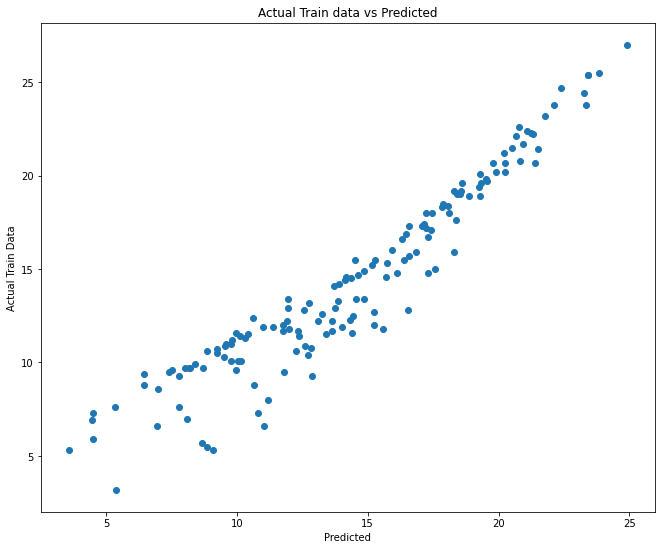

In [164]:
 f, ax = plt.subplots(figsize=(11, 9))
plt.scatter(y_pred, y_train)
plt.xlabel("Predicted")
plt.ylabel("Actual Train Data")
plt.title("Actual Train data vs Predicted")

##### b. Model Predection for Test Data

In [165]:
y_pred_Test = regr.predict(X_test)

In [166]:
df_Test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_Test})
df_Test_results.head()

,Actual,Predicted
18,11.3,10.049457
170,8.4,7.430523
107,8.7,6.971521
98,25.4,24.163787
177,11.7,12.002156


In [167]:
Metrics_Statistics(y_test,y_pred_Test)

R squared:  0.8576396745320892
mean_absolute_error :  1.3000320919235449
mean_squared_error : 4.0124975229171005
Root Mean Squared Error (RMSE) :  2.003121944095541
Mean Absolute Percentage Error (MAPE) :  0.2216611243694418


Text(0.5, 1.0, 'Actual Test data vs Predicted')

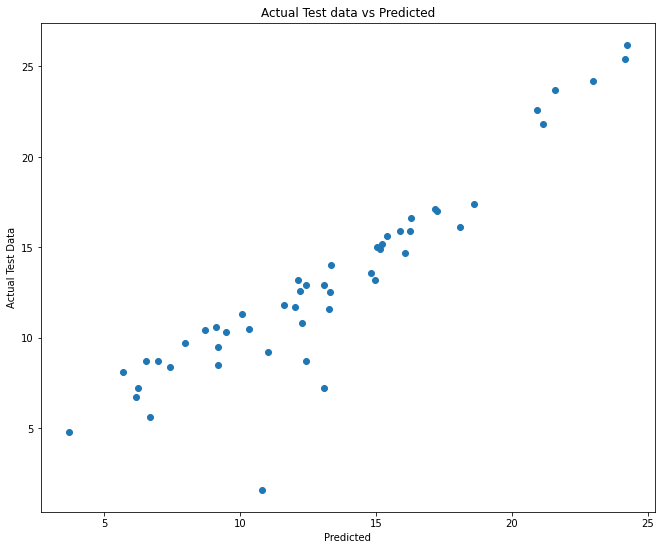

In [168]:
f, ax = plt.subplots(figsize=(11, 9))
plt.scatter(y_pred_Test, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual Test Data")
plt.title("Actual Test data vs Predicted")

### Intercept / Contant value (c)    -----y=mx+c 

In [169]:
# Even if the TV, RADIO & Newspaper Ad's are 0, then also the sales will be 8.910638297872342 units

regr.intercept_

14.351333333333333

### Coefficients of features (m) ------y=mx+c

In [170]:
# sales = m1*tv + m2*radio + m3* newspaper + c

# sales = 3.78*tv + 2.94*radio + 0.02* newspaper + 14.05

regr.coef_

array([3.72650688, 2.94496827, 0.02370631])

In [171]:
pd.DataFrame(regr.coef_.flatten(),
             index=x.columns)

,0
TV,3.726507
Radio,2.944968
Newspaper,0.023706


## <a id="ASSUMPTIONS"> ASSUMPTIONS</a>

## <a id="mean">2. Mean of Residuals</a>

Residuals is the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.


##### On Training Data

In [172]:
residuals_train = y_train.values-y_pred

mean_residuals = np.mean(residuals_train)

print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -4.085620730620576e-16


##### On Test Data

In [173]:
residuals_test = y_test.values-y_pred_Test

mean_residuals = np.mean(residuals_test)

print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -0.11583198439137588


Very close to zero so all good here.

## <a id="homo">3. Check for Homoscedasticity</a>

Homoscedasticity means the residuals are equal across the regression line.

it means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.

## heteroscedastic

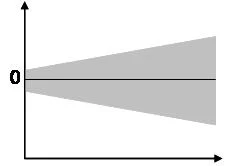

### Detecting heteroscedasticity! 
Graphical Method: Firstly do the regression analysis and then plot the error terms against the predicted values( Yi^). If there is a definite pattern (like linear or quadratic or funnel shaped) obtained from the scatter plot then heteroscedasticity is present.

##### On Train Data

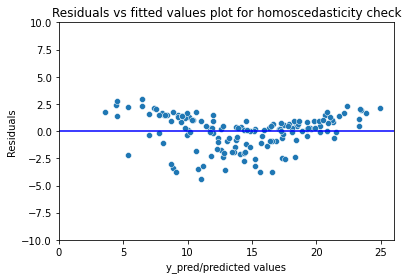

In [174]:
p = sns.scatterplot(y_pred,residuals_train)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

##### On Test Data

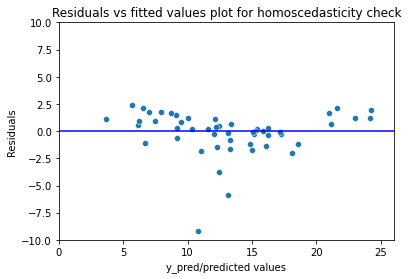

In [175]:
p = sns.scatterplot(y_pred_Test,residuals_test)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

## <a id="normal">4. Check for Normality (normal distribution) of error terms/residuals</a>

##### On Train Data

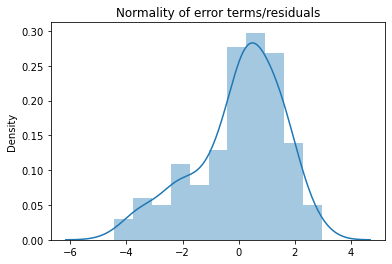

In [176]:
p = sns.distplot(residuals_train,kde=True)
p = plt.title('Normality of error terms/residuals')

##### On Test Data

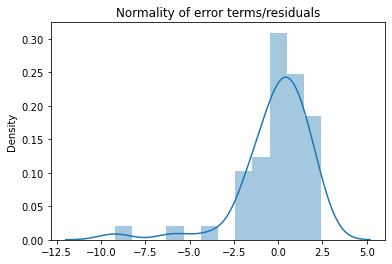

In [177]:
p = sns.distplot(residuals_test,kde=True)
p = plt.title('Normality of error terms/residuals')

The residual terms are pretty much normally distributed for the number of test points we took.

Remember the central limit theorem says that with increases in sample size the distribution tends to become normal. 

A skew is also visible from the plot. It's very difficult to get perfect curves, distributions in real life data.

## <a id="auto">5. No autocorrelation of residuals</a>

When the residuals are autocorrelated, it means that the current value is dependent of the previous (historic) values and that there is a definite unexplained pattern in the Y variable that shows up in the error terms. Though it is more evident in time series data such as seasonality etc

There should not be autocorrelation in the data, so the error terms should not form any pattern.

### Autocorrelation present

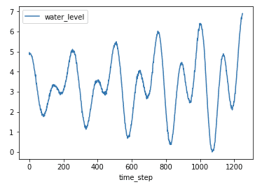

##### On Train Data

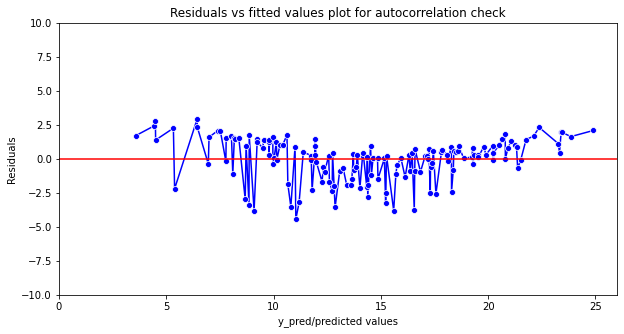

In [178]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y_pred,residuals_train,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='red')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

##### On Test Data

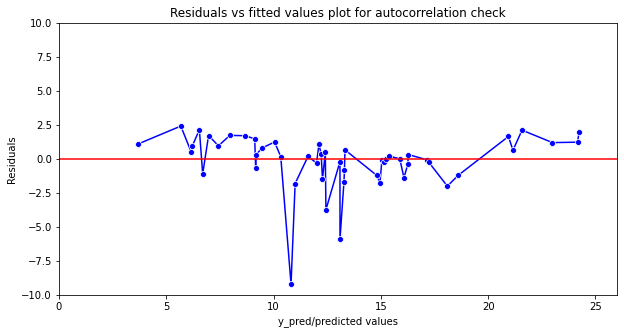

In [179]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y_pred_Test,residuals_test,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='red')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

## <a id="multico">6. No multicollinearity</a>

Multicollinearity occurs when the independent variables are too highly correlated with each other, In regression, multicollinearity refers to the extent to which independent variables are correlated.

Multicollinearity is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. so we can say that both the Independent variables have same kind of information or overlaping information, which is not useful.

Multicollinearity affects the coefficients of the features.

In [180]:
# strong Multicollinearity occurs when correlation is >70% 

ad_data.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


In [181]:
# Newspaper and Radio are correlated but to a lower extend only.

# As a solution/ next iteration re-run the model by removing newspaper column bcz it also didn't followed the linearity 
# assumption and would also solve our Multicollinearity problem too

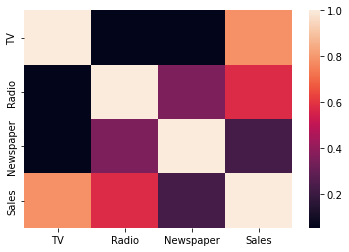

In [182]:
p=sns.heatmap(ad_data.corr()) 

Look for correlation between independent variables and not with dependent variable (Sales in this case) because if a variable is correlated with the dependent variable then this would be a good sign for our model.


# Re-run of the Model for Feature selected

In [50]:
# Remove the Column Newspaper and rebuild the model

In [51]:
import statsmodels.formula.api as smf

In [52]:
lm=smf.ols(formula='Sales~TV + Radio + Newspaper', data=ad_data)
lm_results = lm.fit()
lm_results.params

Intercept    3.264422
TV           0.082131
Radio        0.084407
Newspaper    0.006847
dtype: float64

In [53]:
lm_results.rsquared

0.8550340573551033

In [54]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     116.0
Date:                Fri, 16 Sep 2022   Prob (F-statistic):           1.04e-24
Time:                        22:27:30   Log-Likelihood:                -88.668
No. Observations:                  63   AIC:                             185.3
Df Residuals:                      59   BIC:                             193.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2644      0.360      9.062      0.000       2.544       3.985
TV             0.0821      0.005     17.167      0.000       0.073       0.092
Radio          0.0844      0.009      8.889      0.000       0.065       0.103
Newspaper      0.0068      0.007      0.979      0.331      -0.007       0.021
==============================================================================
Omnibus:                       53.003   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.914
Skew:                          -2.319   Prob(JB):                     3.02e-63
Kurtosis:                      12.390   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P Value for Newspaper is preety high '0.860', hypothesis null testis is pass hence we can remove Newspaper column from model.

In [55]:
x = ad_data.drop(["Sales","Newspaper"],axis=1)
y = ad_data.Sales

In [56]:
x.head(2)

,TV,Radio
1,44.5,39.3
2,17.2,45.9


In [57]:
y.head(2)

1    10.4
2     9.3
Name: Sales, dtype: float64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state = 0, test_size=0.25)

In [59]:
sc = StandardScaler()

In [60]:
X_train = sc.fit_transform(X_train)

In [61]:
X_test = sc.transform(X_test)

In [62]:
#This is just to Inverse the transformation

#a = sc.inverse_transform(X)
#a

In [63]:
regr1 = LinearRegression()
regr1.fit(X_train,y_train)

LinearRegression()

In [64]:
y_pred = regr1.predict(X_train)
df_Train_results = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred})
df_Train_results.head()

,Actual,Predicted
117,9.4,9.623156
135,11.6,11.366833
88,12.9,12.692521
18,11.3,10.746266
46,10.6,11.461703


###### Created re-usalble function (above) to check all metrics:

In [65]:
Metrics_Statistics(y_train,y_pred)

R squared:  0.7742230981446756
mean_absolute_error :  0.6586425720130107
mean_squared_error : 1.0880750020911114
Root Mean Squared Error (RMSE) :  1.0431083366990752
Mean Absolute Percentage Error (MAPE) :  0.13686531285811343


In [66]:
y_pred_Test = regr1.predict(X_test)
df_Test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_Test})
df_Test_results.head()

,Actual,Predicted
132,5.7,6.496359
148,10.9,9.972877
195,7.6,6.840335
155,3.2,4.813080
108,5.3,4.564042


In [67]:
Metrics_Statistics(y_test,y_pred_Test)

R squared:  0.9385199854380238
mean_absolute_error :  0.7517881963242072
mean_squared_error : 0.7531974221501345
Root Mean Squared Error (RMSE) :  0.8678694729912642
Mean Absolute Percentage Error (MAPE) :  0.10939039340707377


In [68]:
# Adjusted R2:
# Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]

#where:

#R2: The R2 of the model
#n: The number of observations
#k: The number of predictor variable
    
Adjusted_R_squared = 1 - (1-regr1.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adjusted_R_squared

0.9290615216592583

In [69]:
regr.coef_

array([2.12644365, 1.09856174, 0.19983348])

In [70]:
regr.intercept_

8.910638297872342

#### Visualization

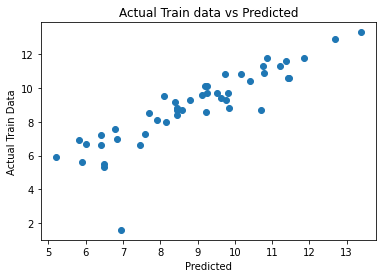

Text(0.5, 1.0, 'Actual Test data vs Predicted')

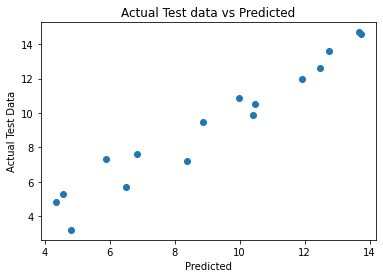

In [71]:
plt.scatter(y_pred, y_train,)
plt.xlabel("Predicted")
plt.ylabel("Actual Train Data")
plt.title("Actual Train data vs Predicted")
plt.show()
plt.scatter(y_pred_Test, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual Test Data")
plt.title("Actual Test data vs Predicted")

Text(0.5, 1.0, 'Residuals Plot')

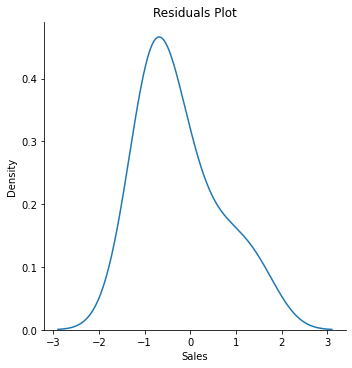

In [72]:
#Residuals plotting
residuals = y_pred_Test-y_test
sns.displot(residuals,kind = 'kde')
plt.title("Residuals Plot")

<AxesSubplot:ylabel='Sales'>

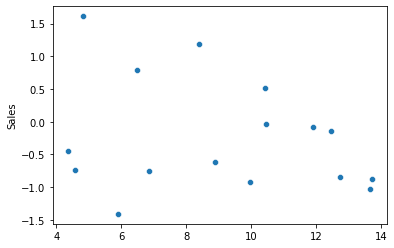

In [73]:
#Scatter plot w.r.t output and residuals
sns.scatterplot(y_pred_Test,residuals)

## Save the model

In [74]:
import pickle

File_save = open("Liner_Regression_model_ADD_marletting_data.pkl",'wb')
pickle.dump(regr1,File_save)
File_save.close()

#### Importing it again

In [75]:
File_read = open("Liner_Regression_model_ADD_marletting_data.pkl",'rb')
pickled_model = pickle.load(File_read)

##### Saving the scaler values for future

In [76]:
File_save = open("Sacler_values_LR_ADD.pkl",'wb')
pickle.dump(sc,File_save)
File_save.close()

##### Using it back

In [77]:
sc_read = open("Sacler_values_LR_ADD.pkl",'rb')
sc_scaled = pickle.load(sc_read)
sc_scaled.feature_names_in_

array(['TV', 'Radio'], dtype=object)

### Predection example in case of New dataset

In [78]:
pickled_model.predict(sc_scaled.transform(X_test))

array([3.41546483, 3.58618821, 3.35513782, 3.30397487, 3.25978916,
       3.66270665, 3.3127341 , 3.54117405, 3.7526585 , 3.5536955 ,
       3.70295624, 3.51072997, 3.25719867, 3.52910454, 3.61879864,
       3.74658619])

In [79]:
pickled_model.score(X_test,y_test)

0.9385199854380238

## KNN Model

In [81]:
KNN_reg = KNeighborsRegressor(n_neighbors=5)
regressor = KNN_reg.fit(X_train, y_train)
y_pred_knn = regressor.predict(X_test)

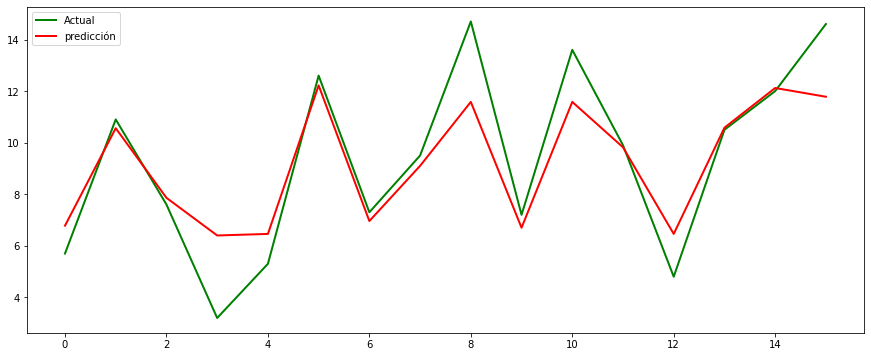

In [82]:
plt.figure(figsize=(15, 6))
plt.plot(list(y_test),  c="g", label="Actual", linewidth=2)
plt.plot(y_pred_knn, c="r", label="predicción", linewidth=2)
plt.legend(loc='best')
plt.show();

In [83]:
def Metrics_Statistics(y_true,y_pred):
    r2_score_value = r2_score(y_true=y_true,y_pred=y_pred)
    MAE = mean_absolute_error(y_true,y_pred)
    MSE = mean_squared_error(y_true,y_pred)
    RMSE = mean_squared_error(y_true,y_pred)**.5
    MAPE = mean_absolute_percentage_error(y_true,y_pred)
    print("R squared: ", r2_score_value )
    print('mean_absolute_error : ', MAE)
    print('mean_squared_error :' , MSE)
    print('Root Mean Squared Error (RMSE) : ', RMSE)
    print('Mean Absolute Percentage Error (MAPE) : ', MAPE)

In [84]:
Metrics_Statistics(y_test,y_pred_knn)

R squared:  0.8053479918884794
mean_absolute_error :  1.0974999999999997
mean_squared_error : 2.3846999999999987
Root Mean Squared Error (RMSE) :  1.5442473895072637
Mean Absolute Percentage Error (MAPE) :  0.16171792247003025


## Decision Tree Model and Random Forest Model

#### Parameter Grid:

In [183]:
# use this structure if you want to try multiple algoriths (with hyper parameter tuning) over your data

model_params = {
    
   'random-forest' : {
       
        'model' : RandomForestRegressor(),
        'params' : {
             "n_estimators": [50, 100, 200, 300, 500], 
             "max_depth": [3, 5, 7, 9, 11, 13],
            
         }
    },
    'decision_tree' :{
        'model' :  DecisionTreeRegressor(),
        'params' : {
             'max_depth': [3, 5, 7, 9, 11, 13],
        }
    },
     'Knn' : {
       
        'model' : KNeighborsRegressor(),
        'params' : {
             "n_neighbors": list(range(1,31)),            
         }
    }
    
}

In [184]:
model_params.items()

dict_items([('random-forest', {'model': RandomForestRegressor(), 'params': {'n_estimators': [50, 100, 200, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]}}), ('decision_tree', {'model': DecisionTreeRegressor(), 'params': {'max_depth': [3, 5, 7, 9, 11, 13]}}), ('Knn', {'model': KNeighborsRegressor(), 'params': {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}})])

#### Model Creation

In [185]:
model_scores = {}

for model_name ,mp in model_params.items():
    
    print('model_name :',model_name,' mp: ', mp,'\n\n')

      
    #clf = RandomizedSearchCV(mp['model'],mp['params'], cv = 3,verbose=3)
    clf = GridSearchCV(mp['model'],mp['params'], cv = 3,verbose=3)
   
    clf.fit(X_train,y_train)
        
    model_scores[model_name]={'best_score' : clf.best_score_,
                              'best_params' : clf.best_params_}

model_name : random-forest  mp:  {'model': RandomForestRegressor(), 'params': {'n_estimators': [50, 100, 200, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]}} 


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END ......max_depth=3, n_estimators=50;, score=0.931 total time=   0.0s
[CV 2/3] END ......max_depth=3, n_estimators=50;, score=0.939 total time=   0.0s
[CV 3/3] END ......max_depth=3, n_estimators=50;, score=0.923 total time=   0.0s
[CV 1/3] END .....max_depth=3, n_estimators=100;, score=0.935 total time=   0.0s
[CV 2/3] END .....max_depth=3, n_estimators=100;, score=0.941 total time=   0.0s
[CV 3/3] END .....max_depth=3, n_estimators=100;, score=0.920 total time=   0.0s
[CV 1/3] END .....max_depth=3, n_estimators=200;, score=0.935 total time=   0.1s
[CV 2/3] END .....max_depth=3, n_estimators=200;, score=0.944 total time=   0.1s
[CV 3/3] END .....max_depth=3, n_estimators=200;, score=0.918 total time=   0.1s
[CV 1/3] END .....max_depth=3, n_estimators=300;, 

[CV 3/3] END .....................n_neighbors=9;, score=0.893 total time=   0.0s
[CV 1/3] END ....................n_neighbors=10;, score=0.880 total time=   0.0s
[CV 2/3] END ....................n_neighbors=10;, score=0.897 total time=   0.0s
[CV 3/3] END ....................n_neighbors=10;, score=0.878 total time=   0.0s
[CV 1/3] END ....................n_neighbors=11;, score=0.884 total time=   0.0s
[CV 2/3] END ....................n_neighbors=11;, score=0.895 total time=   0.0s
[CV 3/3] END ....................n_neighbors=11;, score=0.868 total time=   0.0s
[CV 1/3] END ....................n_neighbors=12;, score=0.879 total time=   0.0s
[CV 2/3] END ....................n_neighbors=12;, score=0.893 total time=   0.0s
[CV 3/3] END ....................n_neighbors=12;, score=0.858 total time=   0.0s
[CV 1/3] END ....................n_neighbors=13;, score=0.877 total time=   0.0s
[CV 2/3] END ....................n_neighbors=13;, score=0.885 total time=   0.0s
[CV 3/3] END ...............

In [186]:
model_scores

{'random-forest': {'best_score': 0.9713574642593491,
  'best_params': {'max_depth': 11, 'n_estimators': 100}},
 'decision_tree': {'best_score': 0.9340036456444745,
  'best_params': {'max_depth': 13}},
 'Knn': {'best_score': 0.9172081543437134, 'best_params': {'n_neighbors': 2}}}

In [187]:
model_scores['Knn']['best_params']['n_neighbors']

2

RF

In [188]:
model_RF=RandomForestRegressor(n_estimators=model_scores['random-forest']['best_params']['n_estimators'], max_depth=model_scores['random-forest']['best_params']['max_depth'])

model_RF.fit(X_train,y_train)

display(
    
    model_RF.score(X_train,y_train),
    
    model_RF.score(X_test,y_test)
    
)

0.9966735427079191

0.9644108755534603

In [189]:
y_pred_train_RF=model_RF.predict(X_train)
y_pred_test_RF=model_RF.predict(X_test)
print(" \n RF Train Metrics :", Metrics_Statistics(y_train,y_pred_train_RF))
print(" \n RF Test Metrics : ",Metrics_Statistics(y_test,y_pred_test_RF))

R squared:  0.9966735427079191
mean_absolute_error :  0.23101666666666593
mean_squared_error : 0.08744135722222175
Root Mean Squared Error (RMSE) :  0.2957048481547466
Mean Absolute Percentage Error (MAPE) :  0.01930091560647447
 
 RF Train Metrics : None
R squared:  0.9644108755534603
mean_absolute_error :  0.6965633333333323
mean_squared_error : 1.0030974094444423
Root Mean Squared Error (RMSE) :  1.0015475073327487
Mean Absolute Percentage Error (MAPE) :  0.1082970212490509
 
 RF Test Metrics :  None


Decision Tree

In [190]:
model_DT=DecisionTreeRegressor(max_depth=model_scores['decision_tree']['best_params']['max_depth'])

model_DT.fit(X_train,y_train)

display(
    
    model_DT.score(X_train,y_train),
    
    model_DT.score(X_test,y_test)
    
)

1.0

0.9002040197684598

In [191]:
y_pred_train_DT=model_DT.predict(X_train)
y_pred_test_DT=model_DT.predict(X_test)
print(" \n DT Train Metrics :", Metrics_Statistics(y_train,y_pred_train_DT))
print(" \n DT Test Metrics : ",Metrics_Statistics(y_test,y_pred_test_DT))

R squared:  1.0
mean_absolute_error :  0.0
mean_squared_error : 0.0
Root Mean Squared Error (RMSE) :  0.0
Mean Absolute Percentage Error (MAPE) :  0.0
 
 DT Train Metrics : None
R squared:  0.9002040197684598
mean_absolute_error :  1.0759999999999998
mean_squared_error : 2.8127999999999997
Root Mean Squared Error (RMSE) :  1.6771404234589302
Mean Absolute Percentage Error (MAPE) :  0.14042064204399562
 
 DT Test Metrics :  None


KNN

In [192]:
model_Knn=KNeighborsRegressor(n_neighbors= 5) #model_scores['Knn']['best_params']['n_neighbors'])

model_Knn.fit(X_train,y_train)

display(
    
    model_Knn.score(X_train,y_train),
    
    model_Knn.score(X_test,y_test)
    
)

0.9618018257222797

0.8971877174876844

In [193]:
y_pred_train_Knn=model_Knn.predict(X_train)
y_pred_test_Knn=model_Knn.predict(X_test)
print(" \n Knn Train Metrics :", Metrics_Statistics(y_train,y_pred_train_Knn))
print(" \n Knn Test Metrics : ",Metrics_Statistics(y_test,y_pred_test_Knn))

R squared:  0.9618018257222797
mean_absolute_error :  0.7445333333333334
mean_squared_error : 1.0041013333333333
Root Mean Squared Error (RMSE) :  1.0020485683505234
Mean Absolute Percentage Error (MAPE) :  0.06835275600500774
 
 Knn Train Metrics : None
R squared:  0.8971877174876844
mean_absolute_error :  1.0699999999999996
mean_squared_error : 2.897816
Root Mean Squared Error (RMSE) :  1.70229727133659
Mean Absolute Percentage Error (MAPE) :  0.18224167086811538
 
 Knn Test Metrics :  None
